# Data Prep

In [1]:
import pickle
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
import plotter as pltr
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from collections import namedtuple
import torch.optim as optim
from mlmetrics.sqlitemetrics.sqlite_metric import SqliteMetric
from haikunator import Haikunator
import logging
from IPython.display import clear_output

logging.basicConfig(level=logging.ERROR)
pltr.set_backend(pltr.MatplotlibBackend)
%matplotlib inline

### Data Exploration

In [2]:
exp = tv.datasets.CIFAR10(root='/data/pytorch/cifar', download=True)

Files already downloaded and verified


#### How do I get to the data (x and y)?
Lets try listing all the public methods on this Dataset.

In [3]:
list(filter(lambda x: not x.startswith('_'), dir(exp)))

['base_folder',
 'download',
 'filename',
 'root',
 'target_transform',
 'test_list',
 'tgz_md5',
 'train',
 'train_data',
 'train_labels',
 'train_list',
 'transform',
 'url']

`train_data` and `train_labels` look promising. What are they?

In [4]:
type(exp.train_data)

numpy.ndarray

In [5]:
exp.train_data.shape

(50000, 32, 32, 3)

In [6]:
print(np.max(exp.train_data), np.min(exp.train_data))

255 0


In [7]:
type(exp.train_labels)

list

In [8]:
len(exp.train_labels)

50000

In [9]:
exp.train_labels[:5]

[6, 9, 9, 4, 1]

Looks like train data has the 50K 32x32 RGB images. The pixel values - as is standard - are between 0 and 255. And the labels are actually the target values $y$.

#### How do I get the label names?
After some quick web search and examining the data directory where the pytorch data is downloaded, there seems to be a batches.meta file which has the `dict` with meta info. Lets load that up.

In [10]:
with open('/data/pytorch/cifar/cifar-10-batches-py/batches.meta', 'rb') as f:
    meta = pickle.load(f)
meta

{'num_cases_per_batch': 10000,
 'label_names': ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'],
 'num_vis': 3072}

In [11]:
def plot_images(images, labels):
    if len(images) != len(labels):
        raise RuntimeError(f'{len(images)} number of images do not match {len(labels)} number of labels!')
    frame = pltr.Frame()
    frame.layout(nrows=1, ncols=len(images))
    
    for image, label in zip(images, labels):
        chart = frame.create_chart()
        chart.title = meta['label_names'][label]
        chart.show_axes = False
        img = pltr.RgbImage(image)
        chart.add(img)
        
    frame.show()

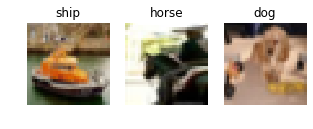

In [12]:
ndxs = np.random.randint(0, 50000, 3)
images = np.take(exp.train_data, ndxs, axis=0)
labels = np.take(exp.train_labels, ndxs, axis=0)
plot_images(images, labels)

# Hyperparameters
It is now time to start thinking about hyperparameters. Lets define a `namedtuple` with as many as we know and then keep adding to it as we go.

In [13]:
HyperParams = namedtuple('HyperParams', ['batch_size', 'learning_rate', 'epochs'])
hparams = HyperParams(batch_size=4, learning_rate=0.01, epochs=5)

# Data Prep
For the architecture I have in mind, it is best that the pixel values are between 0 and 1 and also normalized assuming a mean of 0.5 and std dev of 0.5 for all three channels. Strictly speaking I'd find the μ and σ of each channel across all 50K images and use those values, but the assumption of 0.5 simplifies my life. Additionally, I'll need to convert these images to channel first as that is what pytorch expects. `tv.transforms.ToTensor` will convert the images to channel first as well as convert the pixel values to be between 0 and 1. `tv.transforms.Normalize` will normalize the pixel values.

In [14]:
xform = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
trainset = tv.datasets.CIFAR10(root='/data/pytorch/cifar', train=True, transform=xform)
testset = tv.datasets.CIFAR10(root='/data/pytorch/cifar', train=False, transform=xform)

It is usually useful to deal with the `DataLoader` object instead of with the `Dataset` directly because the `DataLoader` will shuffle the data and give it in a batch. `DataLoader` is also an iterable, i.e., it can be on the left side of a `for loop`; and when passed to the `iter` builtin function, will return an iterator.

In [15]:
devlen = int(len(trainset) * 0.8)
vallen = len(trainset) - devlen
devset, valset = random_split(trainset, (devlen, vallen))
print(len(devset), len(valset))

40000 10000


In [16]:
devloader = DataLoader(devset, batch_size=hparams.batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=hparams.batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=hparams.batch_size, shuffle=True, num_workers=2)

Now lets see what a single batch looks like.

In [17]:
images, labels = iter(devloader).next()
print(type(images), type(labels))

<class 'torch.Tensor'> <class 'torch.Tensor'>


In [18]:
print(images.size(), labels.size())

torch.Size([4, 3, 32, 32]) torch.Size([4])


In [19]:
labels

tensor([4, 5, 6, 8])

In [20]:
print(t.max(images), t.min(images))

tensor(0.9922) tensor(-1.)


All as expected, each batch has 4 images and labels. The images are channel first and pixel values have been normalized to be between -1 and 1.

If we need to visualize these images, we need to first make the image channel last and then de-normalize the pixel values to be in the 0 to 1 range. It is ok if they are not in the 0 to 255 range.

In [21]:
image = images[3].numpy()
image.shape

(3, 32, 32)

In [22]:
dn_image = (image * 0.5) + 0.5
print(np.max(dn_image), np.min(dn_image))

0.9607843 0.043137252


In [23]:
dn_image = np.transpose(dn_image, (1, 2, 0))
dn_image.shape

(32, 32, 3)

In [24]:
label = meta['label_names'][labels[3].item()]
label

'ship'

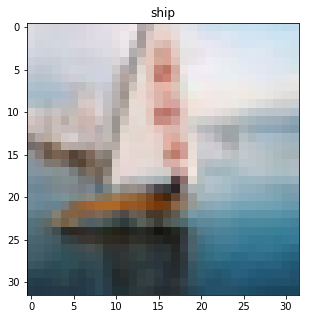

In [25]:
pltr.show_plot(label, pltr.RgbImage(dn_image))

Everything looks good. Now write a function similar to `plot_images` for this.

In [26]:
def plot_normalized_images(images, labels):
    images = images.numpy()
    labels = labels.numpy()
    dn_images = (images * 0.5) + 0.5
    # dn_images is batch_size x channels x height x width
    # it needs to be batch_size x height x width x channels
    # 0, 1, 2, 3 --> 0, 2, 3, 1
    dn_images = np.transpose(dn_images, (0, 2, 3, 1))
    plot_images(dn_images, labels)

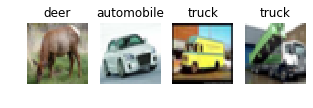

In [27]:
images, labels = iter(devloader).next()
plot_normalized_images(images, labels)

# Scaffolding
Now that the data has been prepared, let us figure out what kind of evaluation metrics we will use and how will we track the loss function values and evaluation metrics. For that let us defined the simplest possible NN, a fully connected single hidden layer that outputs a vector of size 10. The loss function we'll use is `CrossEntropyLoss` because it directly takes in the `h` values, i.e., a vector of size 10, and will convert it into a vector softmax probabilities, take the negative log of these probabilities, and average it across the mini-batch. Very convenient. For evaluation metric we'll again go with the simplest and use accuracy.

In [28]:
class RandomNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(3*32*32, 10)
        
    def forward(self, x):
        x = x.view(-1, 3*32*32)
        h = self.fc(x)
        return h

In [29]:
model = RandomNet()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=hparams.learning_rate, momentum=0.9)

Lets play around with this to see explore the object types.

In [30]:
images, targets = iter(devloader).next()
outputs = model.forward(images)

In [31]:
type(outputs)

torch.Tensor

In [32]:
outputs.size()

torch.Size([4, 10])

Each row in predicted is the output vector of size 10, i.e., each element (i,k) is the probability that the instance i belongs to class k.

In [33]:
loss = loss_fn(outputs, targets)

In [34]:
type(loss)

torch.Tensor

In [35]:
loss.size()

torch.Size([])

An empty size just means that this is a single element tensor. So I can extract the value as `float` primitive just by calling `.item()` on it.

In [36]:
loss.item()

2.622826099395752

### How to find accuracy?
Unlike other libraries, there is no ready-made function in pytorch to calculate accuracy. It can be easily calculated by hand. First I need to pick the max probability from each row in probs to get the predictions, and then simply compare them with the targets.

In [37]:
print(outputs.size())
print(outputs)

torch.Size([4, 10])
tensor([[ 4.7339e-01,  1.4312e-01, -5.0224e-02, -1.3486e-01,  4.1595e-01,
         -1.3945e-01,  1.8546e-04, -3.9532e-01,  2.0345e-01,  1.8651e-01],
        [-4.2511e-01, -2.4672e-01,  1.7751e-01, -1.1969e-01,  6.5483e-01,
          4.1399e-01,  1.1112e-01, -2.3030e-02, -4.9652e-01,  3.1737e-01],
        [ 4.3225e-02,  9.0391e-02,  1.4122e-01, -8.1461e-01,  6.2621e-01,
         -2.0698e-02,  1.4319e-01, -6.5195e-01, -3.2007e-01, -4.5109e-01],
        [-4.0823e-02, -2.6010e-01,  5.5709e-02, -1.9547e-01,  4.1601e-01,
          2.4184e-01, -1.1305e-01, -3.3903e-01,  3.7481e-01, -1.4462e-02]],
       grad_fn=<AddmmBackward>)


In [38]:
# dim=1 will take the max of each row, dim=0 would have taken the max of each col
predicted_vals, predicted_ndxs = t.max(outputs, dim=1)
print(predicted_vals)
print(predicted_ndxs)

tensor([0.4734, 0.6548, 0.6262, 0.4160], grad_fn=<MaxBackward0>)
tensor([0, 4, 4, 4])


As can be seen from above, the predictions are really the indexes, I don't care about the values.

In [39]:
_, predicted = t.max(outputs, dim=1)
predicted

tensor([0, 4, 4, 4])

In [40]:
targets

tensor([5, 8, 3, 8])

In [41]:
predicted == targets

tensor([0, 0, 0, 0], dtype=torch.uint8)

Lets change the predicted tensor to have some matches to ensure that our accuracy calculations are correct.

In [42]:
predicted = t.tensor([0, 3, 1, 2])
predicted

tensor([0, 3, 1, 2])

In [43]:
predicted == targets

tensor([0, 0, 0, 0], dtype=torch.uint8)

Adding all the matches will give me accuracy.

In [44]:
(predicted == targets).sum()

tensor(0)

In [45]:
(predicted == targets).sum().item() / len(predicted)

0.0

Now we have enough information to write a function to calculate accuracy.

In [46]:
def acc_fn(outputs, targets):
    _, predicted = t.max(outputs, dim=1)
    return (predicted == targets).sum().item() / len(predicted)

In [47]:
acc_fn(outputs, targets)

0.0

# Training
The basic training flow is -

  * Train on the dev mini-batch
  * Calculate the loss on the dev mini-batch
  * Evaulate the accuracy on the dev mini-batch
  * After the training is complete on the entire devset
  * Calculate the output of val mini-batch and collect it
  * Calculate the loss on the entire valset at once
  * Evaluate the metrics on the entire valset at once

In [50]:
db = '/data/metrics/classfications.db'

batch_loss_metric = SqliteMetric(db, 'batch_losses', {'run_id', 'epoch', 'batch'})
loss_metric = SqliteMetric(db, 'losses', {'run_id', 'epoch', 'dataset'})
acc_metric = SqliteMetric(db, 'accuracies', {'run_id', 'epoch', 'dataset'})

In [51]:
run_id = Haikunator().haikunate()
run_id

'shrill-leaf-1790'

In [56]:
def process_set(loader):
    # Data in the entire dataset might be too much to process all at once
    # So we process it in batches
    model.eval()
    batch_outputs = []
    batch_targets = []
    for images, targets in loader:
        batch_targets.append(targets)
        with t.no_grad():
            batch_outputs.append(model.forward(images))
    set_outputs = t.cat(batch_outputs)
    set_targets = t.cat(batch_targets)
    setloss = loss_fn(set_outputs, set_targets).item()
    setacc = acc_fn(set_outputs, set_targets)
    return setloss, setacc


for epoch in range(hparams.epochs):
    # Train on the devset
    model.train()
    for batch, (images, targets) in enumerate(devloader):
        with t.enable_grad():
            optimizer.zero_grad()
            outputs = model.forward(images)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            batch_loss_metric.log(run_id=run_id, epoch=str(epoch), batch=str(batch), value=loss.item())
    
    # Calculate the loss and accuracy on the entire devset
    devset_loss, devset_acc = process_set(devloader)
    loss_metric.log(run_id=run_id, epoch=str(epoch), dataset='dev', value=devset_loss)
    acc_metric.log(run_id=run_id, epoch=str(epoch), dataset='dev', value=devset_acc)
    
    # Calculate the loss and accuracy on the entire valset
    valset_loss, valset_acc = process_set(valloader)
    loss_metric.log(run_id=run_id, epoch=str(epoch), dataset='val', value=valset_loss)
    acc_metric.log(run_id=run_id, epoch=str(epoch), dataset='val', value=valset_acc)

batch_loss_metric.close()
loss_metric.close()
acc_metric.close()
print('Finished training')

KeyboardInterrupt: 

### Visualizing Training
We need to see the following live graphs:

  * A chart with a line plot for batch loss
  * A chart with two line plots - one for dev loss and another for val loss
  * A chart with two line plots - one for dev acc and another for val acc

In [53]:
logging.getLogger().setLevel(logging.WARN)

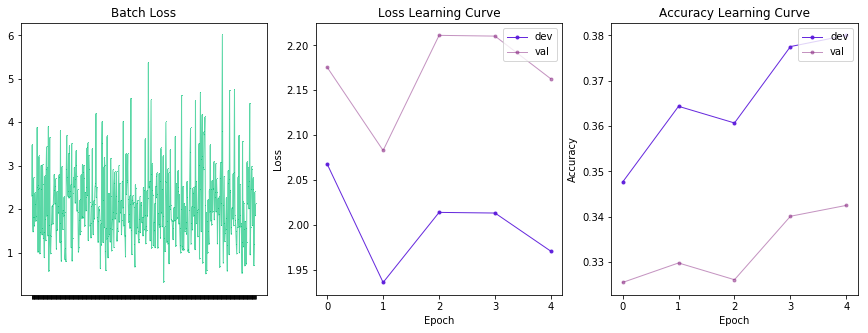

In [54]:
frame = pltr.Frame(height_px=500, width_px=1500)
frame.layout(nrows=1, ncols=3)

batch_loss_chart = frame.create_chart()
batch_loss_chart.title = 'Batch Loss'

batch_loss_logs = batch_loss_metric.logs(run_id=run_id)
losses = []
for log in batch_loss_logs:
    losses.append(log['value'])
xvals = [''] * len(losses)
batch_loss_plot = pltr.Line(categories=xvals[::100], values=losses[::100], marker=pltr.Marker.PIXEL, color=pltr.Color.random())
batch_loss_chart.add(batch_loss_plot)

dev_color = pltr.Color.random()
val_color = pltr.Color.random()

loss_chart = frame.create_chart()
loss_chart.legend_location = pltr.LegendLocation.UPPER_RIGHT
loss_chart.title = 'Loss Learning Curve'
loss_chart.x_axis.label = 'Epoch'
loss_chart.y_axis.label = 'Loss'

dev_loss_logs = loss_metric.logs(run_id=run_id, dataset='dev')
losses = []
epochs = []
for log in dev_loss_logs:
    losses.append(log['value'])
    epochs.append(log['epoch'])
dev_loss_plot = pltr.Line(categories=epochs, values=losses, legend='dev', color=dev_color)
loss_chart.add(dev_loss_plot)

val_loss_logs = loss_metric.logs(run_id=run_id, dataset='val')
losses = []
epochs = []
for log in val_loss_logs:
    losses.append(log['value'])
    epochs.append(log['epoch'])
val_loss_plot = pltr.Line(categories=epochs, values=losses, legend='val', color=val_color)
loss_chart.add(val_loss_plot)


acc_chart = frame.create_chart()
acc_chart.legend_location = pltr.LegendLocation.UPPER_RIGHT
acc_chart.title = 'Accuracy Learning Curve'
acc_chart.x_axis.label = 'Epoch'
acc_chart.y_axis.label = 'Accuracy'

dev_acc_logs = acc_metric.logs(run_id=run_id, dataset='dev')
acc = []
epochs = []
for log in dev_acc_logs:
    acc.append(log['value'])
    epochs.append(log['epoch'])
dev_acc_plot = pltr.Line(categories=epochs, values=acc, legend='dev', color=dev_color)
acc_chart.add(dev_acc_plot)

val_acc_logs = acc_metric.logs(run_id=run_id, dataset='val')
acc = []
epochs = []
for log in val_acc_logs:
    acc.append(log['value'])
    epochs.append(log['epoch'])
val_acc_plot = pltr.Line(categories=epochs, values=acc, legend='val', color=val_color)
acc_chart.add(val_acc_plot)

frame.show()

# Architecture
Now that the scaffolding is ready, its time to define the architecture.

![pytorch_cifar_arch.png](./pytorch_cifar_arch.png)

In [48]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        a1 = self.pool(F.relu(self.conv1(x)))
        a2 = self.pool(F.relu(self.conv2(a1)))
        a2 = x.view(-1, 16*5*5)
        a3 = F.relu(self.fc1(a2))
        a4 = F.relu(self.fc2(a3))
        h = self.fc3(a4)
        return h

In [55]:
hparams = HyperParams(batch_size=16, learning_rate=0.001, epochs=5)

model = RandomNet()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=hparams.learning_rate, momentum=0.9)

At this point I'll implement the training module outside of Jupyter.

In [ ]:
batch_loss_metric.close()
loss_metric.close()
acc_metric.close()